Loading intrinsic population
Loading GW population
Loading EM population (kilonova)
Loading EM population (GRB afterglow)
Loading EM population (GRB prompt)
Computing GW limiting thresholds
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing SSC limiting thresholds
Computing GRB PROMPT limiting thresholds
Plotting detection rates
ET: ETT
EoS: SFHo
mass: fiducial
\Fraction HMNS:  52.214186442941745
Computing GW limiting thresholds
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing SSC limiting thresholds
Computing GRB PROMPT limiting thresholds
Plotting detection rates
ET: ETT
EoS: SFHo
mass: gaussian
\Fraction HMNS:  66.51545098455911
Computing GW limiting thresholds
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing SSC limiting thresholds
Computing GRB PROMPT limiting thresholds
Plotting detection rates
ET: ETT
EoS: SFHo
mass: uniform
\Fraction HMNS:  48.84866265359283
Loading i

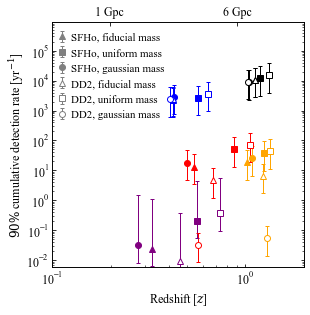

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
from functions_ET import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import *  
import warnings
warnings.filterwarnings("ignore")
    
#recomp_gaussian = False
#recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
#plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize']=4.5,4.5
#plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
#plt.rcParams["axes.axisbelow"] = False
plt.rcParams['legend.handlelength'] = 0

fig1,ax = plt.subplots(1,1)

num = 1000000
### --- Weights --- ###
mass = ['fiducial','gaussian','uniform']

marker_style = ['^','o','s']
inside_style = [None,'w']

eos = ["SFHo","DD2"]

runs = ["ETT"]

lim_snr = 12.

lim_kn = np.array([26.,24.4,21.])

lim_grb = np.asarray([1.e-2,1.5e-4,1.5e-6])

lim_prompt_fermi = 3.09e-7
duty_fermi = 0.6
duty_CTA = 0.07
        
for h in range(len(runs)):
    for k in range(len(eos)):
        if k == 0:
            mns_max = 2.058838
        if k == 1:
            mns_max = 2.422658
        table = h5py.File('../horizons2/population/computed_population/nsns_%i_%s_GWFAST.hdf5' %(num,eos[k]),'r')
        
        ### --- Loading Population --- ###
        
        print("Loading intrinsic population")
        m1 = table['m1'][()]
        m2 = table['m2'][()]
        lamb1 = table['lamb1'][()]
        lamb2 = table['lamb2'][()]
        z = table['z'][()]
        dL = table['dL'][()]
        thv = table['thv'][()]
        ra = table['ra'][()]
        dec = table['dec'][()]
        pol = table['pol'][()]
        m_dyn = table['m_dyn'][()]
        v_dyn = table['v_dyn'][()]
        m_disk = table['m_disk'][()]
        m_gw = table['m_gw'][()]
        E_bkt = table['E_bkt'][()]
        E_k_jet = table['E_k_jet'][()]
        Ec = table['Ec'][()]
        L_sb = table['L_sb'][()]
        Eiso_sb = table['Eiso_sb'][()]
        Epeak_sb = table['Epeak_sb'][()]
        csi_w = 0.05; csi_s = 0.2
        m_rem = m1 + m2 - m_gw - m_disk - m_dyn
        
        print("Loading GW population")
        snr_ETT = table['snr_ETT'][()]
        sky_loc_ETTnew = table['sky_loc_ETT'][()]
        snr_ETL = table['snr_ETL'][()]
        sky_loc_ETL = table['sky_loc_ETL'][()]        
        
        print("Loading EM population (kilonova)")
        kn_waves = table['kn_waves'][()]
        t_kn = table['t_kn'][()]
        lc_kn = table['lc_kn'][()]
        
        print("Loading EM population (GRB afterglow)")
        grb_nu = table['grb_nu'][()]
        grb_nu_SSC = table['grb_nu_SSC'][()]
        t_grb = table['t_grb'][()]
        t_grb_SSC = table['t_grb_SSC'][()]
        th = table['th'][()]
        lc_grb = table['lc_grb'][()]
        lc_grb_SSC_NoEBL = table['lc_grb_SSC'][()]
        lc_grb_SSC_NoEBL_highdens = table['lc_grb_SSC_highdens'][()]
        attenuation_EBL = table['attenuation_EBL'][()]
        lc_grb_SSC = lc_grb_SSC_NoEBL * attenuation_EBL[:, :, np.newaxis]
        lc_grb_SSC_highdens = lc_grb_SSC_NoEBL_highdens * attenuation_EBL[:, :, np.newaxis]
        
        print("Loading EM population (GRB prompt)")
        bol_fluence_prompt = table['bol_fluence_prompt'][()]
        bol_fluence_prompt_tot = table['bol_fluence_prompt_tot'][()]
        
        table.close()
        
        np.random.seed(0)
        
        #Redshift z
        r0BNS = 347/1.85
        r0BNS_high = (347+536)/1.85
        r0BNS_low = (347-256)/1.85 

        tcosmo = np.arange(0.,13.,5.e-2)*1.e9
        zeta_0 = np.linspace(10**(-2.3),10**(0.6),1000)
        tcosmo_0 = cosmo.lookback_time(zeta_0).value*1.e9
        zp=np.interp(tcosmo,tcosmo_0,zeta_0)
        phi = 0.015*((1+zp)**(2.7))/(1+((1+zp)/2.9)**5.6)

        rd = np.zeros(len(tcosmo))
        for i in range(len(rd)-1):
            y = phi*(tcosmo-tcosmo[i])**-1
            rd[i] = np.trapz(y[i+1:],tcosmo[i+1:])

        rho = np.interp(z,zp,rd)*(r0BNS/rd[0])
        dvdz=4.*np.pi*cosmo.differential_comoving_volume(z).to("Gpc3 sr-1").value
        dpdz=rho*dvdz/(1+z)
        w_z = dpdz*z

        #Viewing angle
        w_thv = np.sin(thv)
        
        for i in range (len(mass)):
            if i == 0:
                w_m1,w_m2 = mass_colombo22(m1,m2)
            if i == 1:
                w_m1,w_m2 = mass_gauss(m1,m2)
            if i == 2:
                w_m1 = np.ones_like(m1)
                w_m2 = np.ones_like(m1)

            #Total
            w = w_m1 * w_m2 * w_z * w_thv

            #Monte Carlo
            z_new = np.linspace(10**(-2.3),10**(0.6),10000)
            rho = np.interp(z_new,zp,rd)*(r0BNS/rd[0])
            dvdz=4.*np.pi*cosmo.differential_comoving_volume(z_new).to("Gpc3 sr-1").value
            dpdz=rho*dvdz/(1+z_new)
            C_mc = np.trapz(dpdz,z_new)/np.sum(w)

            #error_high
            rho_high = np.interp(z,zp,rd)*(r0BNS_high/rd[0])
            dvdz_high=4.*np.pi*cosmo.differential_comoving_volume(z).to("Gpc3 sr-1").value
            dpdz_high=rho_high*dvdz_high/(1+z)
            w_z_high = dpdz_high*z

            w_high = w_m1 * w_m2 * w_z_high * w_thv

            z_new = np.linspace(10**(-2.3),10**(0.6),10000)
            rho_high = np.interp(z_new,zp,rd)*(r0BNS_high/rd[0])
            dvdz_high=4.*np.pi*cosmo.differential_comoving_volume(z_new).to("Gpc3 sr-1").value
            dpdz_high=rho_high*dvdz_high/(1+z_new)
            C_mc_high = np.trapz(dpdz_high,z_new)/np.sum(w_high)

            #error_low
            rho_low = np.interp(z,zp,rd)*(r0BNS_low/rd[0])
            dvdz_low=4.*np.pi*cosmo.differential_comoving_volume(z).to("Gpc3 sr-1").value
            dpdz_low=rho_low*dvdz_low/(1+z)
            w_z_low = dpdz_low*z

            w_low = w_m1 * w_m2 * w_z_low * w_thv

            z_new = np.linspace(10**(-2.3),10**(0.6),10000)
            rho_low = np.interp(z_new,zp,rd)*(r0BNS_low/rd[0])
            dvdz_low=4.*np.pi*cosmo.differential_comoving_volume(z_new).to("Gpc3 sr-1").value
            dpdz_low=rho_low*dvdz_low/(1+z_new)
            C_mc_low = np.trapz(dpdz_low,z_new)/np.sum(w_low)
            
            
            #GW
            print("Computing GW limiting thresholds")
            np.random.seed(0)
    
            if h == 0:
                gw_det = snr_ETT >= lim_snr
            
            if h == 1:
                gw_det = snr_ETL >= lim_snr
            
    
            #KILONOVA
            print("Computing KN limiting thresholds")
            kn_peak = np.min(lc_kn, axis=2)
            kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
            for j in range(len(kn_waves)):
                kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
                kn_det[:,j] = kn_peak_APP <= lim_kn[j]
            kn_det_all = np.max(kn_det, axis = 1)
            kn_det_g = kn_det[:,0]
            kn_det_r = kn_det[:,1]
            kn_det_J = kn_det[:,2]
            
            #GRB AFTERGLOW
            print("Computing GRB AFTERGLOW limiting thresholds")
            grb_peak = np.max(lc_grb, axis=2)
            grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
            for j in range(len(grb_nu)):
                grb_det[:,j] = grb_peak[:,j] >= lim_grb[j]
            grb_det_all = np.max(grb_det, axis = 1)
            grb_det_radio = grb_det[:,0]
            grb_det_optic = grb_det[:,1]
            grb_det_x = grb_det[:,2]
            
            print("Computing SSC limiting thresholds")

            det_SSC = np.zeros([num, len(grb_nu_SSC)])
            det_SSC_highdens = np.zeros([num, len(grb_nu_SSC)])

            # Determine the hemisphere for each event based on the declination of the event
            emispheres = determine_emisphere(dec)

            # Calculate sensitivities for both bands and both hemispheres at once
            sensitivity_01 = sensitivity_CTA_vectorized(emispheres, "0.1", t_grb_SSC)
            sensitivity_1 = sensitivity_CTA_vectorized(emispheres, "1", t_grb_SSC)

            # Apply sensitivity thresholds to detect events
            mask_01 = lc_grb_SSC[:, 1, :] > sensitivity_01  # Broadcasting comparison
            mask_1 = lc_grb_SSC[:, 2, :] > sensitivity_1    # Broadcasting comparison
            mask_01_highdens = lc_grb_SSC_highdens[:, 1, :] > sensitivity_01  # Broadcasting comparison
            mask_1_highdens = lc_grb_SSC_highdens[:, 2, :] > sensitivity_1    # Broadcasting comparison

            # Use np.any along the time dimension to find detected events
            det_SSC[:, 1] = np.any(mask_01, axis=1)
            det_SSC[:, 2] = np.any(mask_1, axis=1)
            det_SSC_highdens[:, 1] = np.any(mask_01_highdens, axis=1)
            det_SSC_highdens[:, 2] = np.any(mask_1_highdens, axis=1)

            # Final detection mask
            grb_det_SSC_CTA = np.max(det_SSC, axis=1)  # Mask of 0 or 1, depending on detection in at least one band
            grb_det_SSC_CTA_highdens = np.max(det_SSC_highdens, axis=1)  # Mask of 0 or 1, depending on detection in at least one band
            
            #GRB PROMPT
            print("Computing GRB PROMPT limiting thresholds")
            prompt_det_fermi = bol_fluence_prompt_tot >= lim_prompt_fermi ######CHANGE THIS LINE
            
            ### --- Computing detection Rates --- ###
            
            x = np.sort(z)
            s = np.argsort(z)
            
            #ALL NSNS
            cum_tot = C_mc*np.cumsum(w[s])
            cum_tot_high = C_mc_high*np.cumsum(w_high[s])
            cum_tot_low = C_mc_low*np.cumsum(w_low[s])
            
            #GW
            #cum_gw_O3 = C_mc*np.cumsum(w[s]*gw_det_O3[s])
            cum_gw = C_mc*np.cumsum(w[s]*gw_det[s])
            cum_gw_norm = cum_gw/cum_gw[-1]
            cum_gw_high = C_mc_high*np.cumsum(w_high[s]*gw_det[s])
            cum_gw_low = C_mc_low*np.cumsum(w_low[s]*gw_det[s])
            
            #KN
            cum_gw_kn_g = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
            cum_gw_kn_g_high = C_mc_high*np.cumsum(w_high[s]*kn_det_g[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
            cum_gw_kn_g_low = C_mc_low*np.cumsum(w_low[s]*kn_det_g[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
            cum_gw_kn_g_norm = cum_gw_kn_g/cum_gw_kn_g[-1]
            
            #GRB AFTERGLOW
            cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
            cum_gw_grb_radio_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
            cum_gw_grb_radio_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
            cum_gw_grb_radio_norm = cum_gw_grb_radio/cum_gw_grb_radio[-1]
            
            cum_gw_SSC_CTA =  C_mc*np.cumsum(w[s]*grb_det_SSC_CTA[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
            cum_gw_SSC_CTA_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_SSC_CTA[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
            cum_gw_SSC_CTA_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_SSC_CTA[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
            cum_gw_SSC_CTA_norm = cum_gw_SSC_CTA/cum_gw_SSC_CTA[-1]
            
            cum_gw_SSC_CTA_highdens =  C_mc*np.cumsum(w[s]*grb_det_SSC_CTA_highdens[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
            cum_gw_SSC_CTA_highdens_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_SSC_CTA_highdens[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
            cum_gw_SSC_CTA_highdens_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_SSC_CTA_highdens[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
            cum_gw_SSC_CTA_highdens_norm = cum_gw_SSC_CTA_highdens/cum_gw_SSC_CTA_highdens[-1]

            #GRB PROMPT 
            cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))

            cum_gw_fermi_norm = cum_gw_fermi/cum_gw_fermi[-1]
            cum_gw_fermi_high = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
            cum_gw_fermi_low = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi[s]*gw_det[s]*(m_rem[s]>1.2*mns_max))
            
            ### --- Plotting detection Rates --- ###
            print("Plotting detection rates")
            skip = 30000
            skip2 = 1
            perc = 0.9
            xgw = np.interp(perc,cum_gw_norm[::skip],x[::skip])
            ygw = np.interp(xgw,x[::skip],cum_gw[::skip])
            xkn = np.interp(perc,cum_gw_kn_g_norm[::skip2],x[::skip2])
            ykn = np.interp(xkn,x[::skip],cum_gw_kn_g[::skip])
            xfermi = np.interp(perc,cum_gw_fermi_norm[::skip],x[::skip])
            yfermi = np.interp(xfermi,x[::skip],cum_gw_fermi[::skip]*duty_fermi)
            #xgrb = 10**(np.interp(np.log10(perc),np.log10(cum_gw_grb_radio_norm[::skip]),np.log10(x[::skip])))
            xgrb = np.interp(perc,cum_gw_grb_radio_norm[::skip],x[::skip])
            ygrb = np.interp(xgrb,x[::skip],cum_gw_grb_radio[::skip])
            xssc = np.interp(perc,cum_gw_SSC_CTA_norm[::skip],x[::skip])
            yssc= np.interp(xssc,x[::skip],cum_gw_SSC_CTA[::skip]*duty_CTA)
            xssc_highdens = np.interp(perc,cum_gw_SSC_CTA_highdens_norm[::skip],x[::skip])
            yssc_highdens= np.interp(xssc_highdens,x[::skip],cum_gw_SSC_CTA_highdens[::skip]*duty_CTA)
            
            errorGW_low = np.interp(xgw,x[::skip],cum_gw[::skip]) - np.interp(xgw,x[::skip],cum_gw_low[::skip])
            errorGW_high = np.interp(xgw,x[::skip],cum_gw_high[::skip]) - np.interp(xgw,x[::skip],cum_gw[::skip])
            errorGW = np.array([[errorGW_low,errorGW_high]]).T
            
            errorKN_low = np.interp(xkn,x[::skip],cum_gw_kn_g[::skip]) - np.interp(xkn,x[::skip],cum_gw_kn_g_low[::skip])
            errorKN_high = np.interp(xkn,x[::skip],cum_gw_kn_g_high[::skip]) - np.interp(xkn,x[::skip],cum_gw_kn_g[::skip])
            errorKN = np.array([[errorKN_low,errorKN_high]]).T
            
            errorGRB_low = np.interp(xgrb,x[::skip],cum_gw_grb_radio[::skip]) - np.interp(xgrb,x[::skip],cum_gw_grb_radio_low[::skip])
            errorGRB_high = np.interp(xgrb,x[::skip],cum_gw_grb_radio_high[::skip]) - np.interp(xgrb,x[::skip],cum_gw_grb_radio[::skip])
            errorGRB = np.array([[errorGRB_low,errorGRB_high]]).T
            
            errorSSC_low = np.interp(xssc,x[::skip],cum_gw_SSC_CTA[::skip]*duty_CTA) - np.interp(xssc,x[::skip],cum_gw_SSC_CTA_low[::skip]*duty_CTA)
            errorSSC_high = np.interp(xssc,x[::skip],cum_gw_SSC_CTA_high[::skip]*duty_CTA) - np.interp(xssc,x[::skip],cum_gw_SSC_CTA[::skip]*duty_CTA)
            errorSSC = np.array([[errorSSC_low,errorSSC_high]]).T
            
            errorSSC_highdens_low = np.interp(xssc_highdens,x[::skip],cum_gw_SSC_CTA_highdens[::skip]*duty_CTA) - np.interp(xssc_highdens,x[::skip],cum_gw_SSC_CTA_highdens_low[::skip]*duty_CTA)
            errorSSC_highdens_high = np.interp(xssc_highdens,x[::skip],cum_gw_SSC_CTA_highdens_high[::skip]*duty_CTA) - np.interp(xssc_highdens,x[::skip],cum_gw_SSC_CTA_highdens[::skip]*duty_CTA)
            errorSSC_highdens = np.array([[errorSSC_highdens_low,errorSSC_highdens_high]]).T
            
            def error_variation(y,error_y,y_var,error_y_var):
                # Calcolo dei valori massimi e minimi
                y_min = y - error_y[0]  # Minimo di yssc
                y_max = y + error_y[1]  # Massimo di yssc
                
                y_var_min = y_var - error_y_var[0]  # Minimo di yssc_highdens
                y_var_max = y_var + error_y_var[1]  # Massimo di yssc_highdens
                
                # Determinazione degli estremi globali per le barre di errore
                global_min = np.minimum(y_min, y_var_min)  # Valore minimo globale
                global_max = np.maximum(y_max, y_var_max)  # Valore massimo globale
                
                # Calcolo delle nuove barre di errore per yssc
                new_error_low = y - global_min
                new_error_high = global_max - y
                errorSSC_new = np.array([new_error_low,new_error_high])
                
                return errorSSC_new
            
            errorSSC_new = error_variation(yssc,errorSSC,yssc_highdens,errorSSC_highdens)
            
            
            errorFERMI_low = np.interp(xfermi,x[::skip],cum_gw_fermi[::skip]*duty_fermi) - np.interp(xfermi,x[::skip],cum_gw_fermi_low[::skip]*duty_fermi)
            errorFERMI_high = np.interp(xfermi,x[::skip],cum_gw_fermi_high[::skip]*duty_fermi) - np.interp(xfermi,x[::skip],cum_gw_fermi[::skip]*duty_fermi)
            errorFERMI = np.array([[errorFERMI_low,errorFERMI_high]]).T            
  
            ax.errorbar(xgw,ygw,c='black',marker=marker_style[i],yerr=errorGW,elinewidth=1,capsize=2,mfc=inside_style[k])
            ax.errorbar(xkn,ykn,c='blue',marker=marker_style[i],yerr=errorKN,elinewidth=1,capsize=2,mfc=inside_style[k])
            ax.errorbar(xfermi,yfermi,ls="-",c='orange',marker=marker_style[i],yerr=errorFERMI,elinewidth=1,capsize=2,mfc=inside_style[k])
            ax.errorbar(xgrb,ygrb,ls="-",c='red',marker=marker_style[i],yerr=errorGRB,elinewidth=1,capsize=2,mfc=inside_style[k])
            ax.errorbar(xssc,yssc,ls="-",c='purple',marker=marker_style[i],yerr=errorSSC_new,elinewidth=1,capsize=2,mfc=inside_style[k])
            
            print("ET:", runs[h])
            print("EoS:", eos[k])
            print("mass:", mass[i])
            print("\Fraction HMNS: ", 100*np.sum(w*(m_disk>1.e-5)*(m_rem>1.2*mns_max)*gw_det)/np.sum(w*gw_det))
          
    
    ax.errorbar(1000,100000,ls="-",c='grey',marker="^",yerr=1.,elinewidth=1,capsize=2,mfc=None,label="SFHo, fiducial mass")
    ax.errorbar(1000,100000,ls="-",c='grey',marker="s",yerr=1.,elinewidth=1,capsize=2,mfc=None,label="SFHo, uniform mass")
    ax.errorbar(1000,100000,ls="-",c='grey',marker="o",yerr=1.,elinewidth=1,capsize=2,mfc=None,label="SFHo, gaussian mass")
    ax.errorbar(1000,100000,ls="-",c='grey',marker="^",yerr=1.,elinewidth=1,capsize=2,mfc="w",label="DD2, fiducial mass")
    ax.errorbar(1000,100000,ls="-",c='grey',marker="s",yerr=1.,elinewidth=1,capsize=2,mfc="w",label="DD2, uniform mass")
    ax.errorbar(1000,100000,ls="-",c='grey',marker="o",yerr=1.,elinewidth=1,capsize=2,mfc="w",label="DD2, gaussian mass")
    ax.legend(loc=2,frameon=False,prop={'size': 11})
    
    ylim = (0.006,9.e5)
    xlim = (0.1,2.)
    ax.set_xlabel('Redshift [$z$]',size=12)
    if h == 0:
        ax.set_ylabel(r'$90\%$ cumulative detection rate [yr$^{-1}$]',size=12)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.minorticks_on()
    ax2 = ax.twiny()
    ax2.set_xlim(xlim)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.minorticks_off()
    ax2.set_xticks([0.198,0.9045])
    ax2.set_xticklabels(('1 Gpc','6 Gpc'),size=12)
    if h == 1:
        ax.tick_params(axis = 'y',direction='in',which='both',right=True,labelsize=0,labelcolor="white",zorder=2)
        ax.tick_params(axis = 'x',direction='in',which='both',labelsize=12)
    if h == 0:
        ax.tick_params(direction='in',which='both',right=True,labelsize=12,zorder=2)
    ax2.tick_params(direction='in',which='both',zorder=2)
    ax.yaxis.labelpad = 0.1
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.show()